In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


In [3]:
transform = transforms.ToTensor()

dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform
)


Files already downloaded and verified


C:\Users\mateo\AppData\Roaming\Python\Python312\site-packages\torchvision\datasets\cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


In [4]:
images = []
labels = []

count_plane = 0
count_car = 0

for img, label in dataset:
    if label == 0 and count_plane < 10:
        images.append(img)
        labels.append(label)
        count_plane += 1
    elif label == 1 and count_car < 10:
        images.append(img)
        labels.append(label)
        count_car += 1

    if count_plane == 10 and count_car == 10:
        break


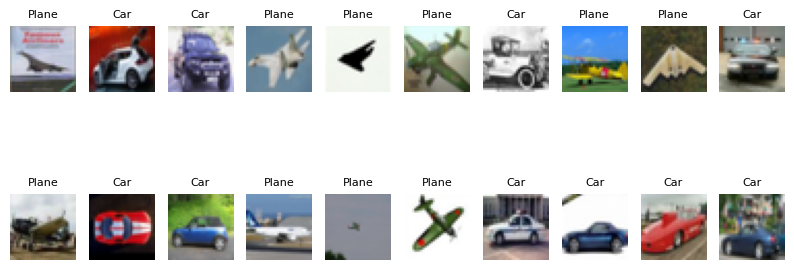

In [5]:
plt.figure(figsize=(10, 4))
for i, img in enumerate(images):
    plt.subplot(2, 10, i + 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.axis("off")
    plt.title("Plane" if labels[i] == 0 else "Car", fontsize=8)
plt.show()


In [6]:
def to_gray(img):
    r, g, b = img
    gray = 0.299*r + 0.587*g + 0.114*b
    return gray.unsqueeze(0).unsqueeze(0)  # [1,1,32,32]


In [68]:
sobel_x = torch.tensor(
    [[5, 0, -5],
    [5, 0, -5],
    [5, 0, -5]], dtype=torch.float32
).view(1, 1, 3, 3)

sobel_y = torch.tensor(
    [[-5, -5, -5],
     [ 0,  0,  0],
     [ 5,  5,  5]], dtype=torch.float32
).view(1, 1, 3, 3)




In [69]:
def sobel_features(img):
    gray = to_gray(img)
    gx = F.conv2d(gray, sobel_x, padding=1)
    gy = F.conv2d(gray, sobel_y, padding=1)

    energy_x = gx.abs().mean().item()  # bordes verticales
    energy_y = gy.abs().mean().item()  # bordes horizontales

    return energy_x, energy_y


In [70]:
def classify_auto_plane(ex, ey):
    if ey > ex:
        return 0  # airplane
    else:
        return 1  # automobile


In [71]:
predictions = []

for img in images:
    ex, ey = sobel_features(img)
    pred = classify_auto_plane(ex, ey)
    predictions.append(pred)


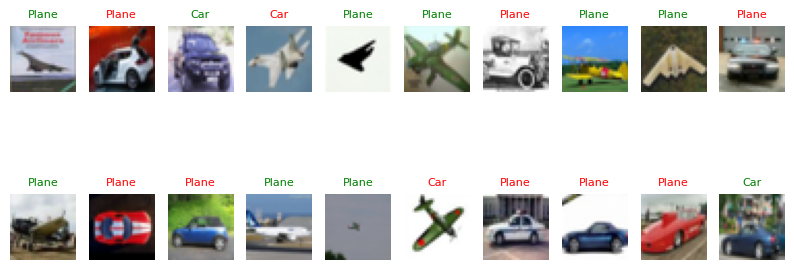

In [72]:
plt.figure(figsize=(10, 4))
for i, img in enumerate(images):
    plt.subplot(2, 10, i + 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.axis("off")

    true_label = "Plane" if labels[i] == 0 else "Car"
    pred_label = "Plane" if predictions[i] == 0 else "Car"

    color = "green" if labels[i] == predictions[i] else "red"
    plt.title(pred_label, color=color, fontsize=8)

plt.show()


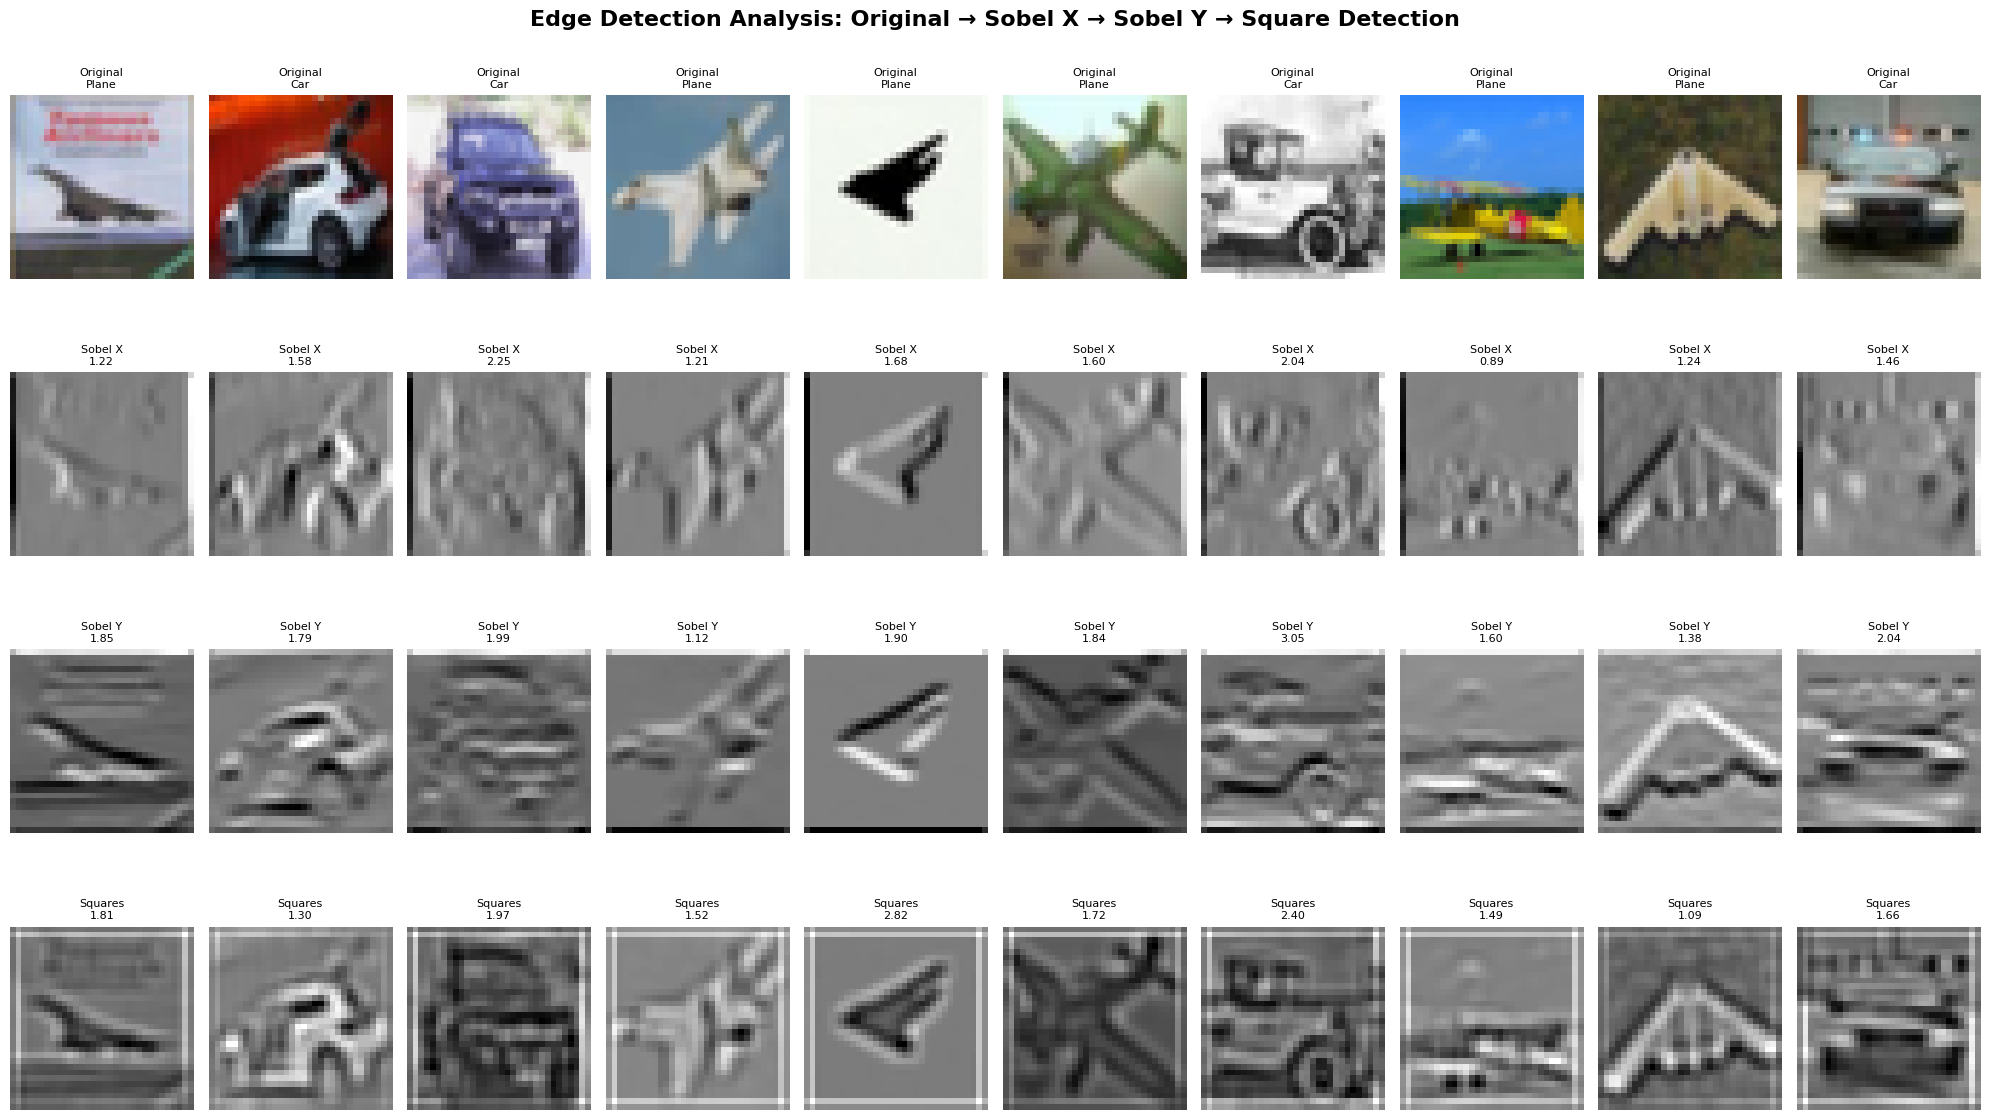

In [75]:
plt.figure(figsize=(20, 12))

for i, img in enumerate(images[:10]):  # Limit to first 10 images to fit in 4x10 grid
    # Convert to grayscale
    gray = to_gray(img)
    
    # Apply Sobel filters
    gx = F.conv2d(gray, sobel_x, padding=1)
    gy = F.conv2d(gray, sobel_y, padding=1)
    
    # Apply square detection filter
    square_response = F.conv2d(gray, square_contrast, padding=2)
    
    # Calculate combined edge magnitude
    edge_magnitude = torch.sqrt(gx**2 + gy**2)
    
    # Original image
    plt.subplot(4, 10, i + 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.axis('off')
    plt.title(f"Original\n{'Plane' if labels[i] == 0 else 'Car'}", fontsize=8)
    
    # Sobel X (vertical edges)
    plt.subplot(4, 10, i + 11)
    plt.imshow(gx.squeeze().detach().numpy(), cmap='gray')
    plt.axis('off')
    plt.title(f"Sobel X\n{sobel_features(img)[0]:.2f}", fontsize=8)
    
    # Sobel Y (horizontal edges)
    plt.subplot(4, 10, i + 21)
    plt.imshow(gy.squeeze().detach().numpy(), cmap='gray')
    plt.axis('off')
    plt.title(f"Sobel Y\n{sobel_features(img)[1]:.2f}", fontsize=8)
    
    # Square detection
    plt.subplot(4, 10, i + 31)
    plt.imshow(square_response.squeeze().detach().numpy(), cmap='gray')
    plt.axis('off')
    plt.title(f"Squares\n{square_features(img):.2f}", fontsize=8)

plt.suptitle('Edge Detection Analysis: Original → Sobel X → Sobel Y → Square Detection', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [76]:
correct = 0
for i in range(len(labels)):
    if labels[i] == predictions[i]:
        correct += 1

accuracy = correct / len(labels)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 50.00%


🔲 CLASIFICADOR MEJORADO: Sobel + Detección de Cuadrados
Imagen   Real     Pred     E_X    E_Y    E_Square Correcto
----------------------------------------------------------------------
1        Plane    Plane    1.22   1.85   1.81     ✓       
2        Car      Plane    1.58   1.79   1.30     ✗       
3        Car      Car      2.25   1.99   1.97     ✗       
4        Plane    Car      1.21   1.12   1.52     ✗       
5        Plane    Car      1.68   1.90   2.82     ✗       
6        Plane    Plane    1.60   1.84   1.72     ✓       
7        Car      Car      2.04   3.05   2.40     ✓       
8        Plane    Plane    0.89   1.60   1.49     ✓       
9        Plane    Plane    1.24   1.38   1.09     ✓       
10       Car      Plane    1.46   2.04   1.66     ✗       
11       Plane    Plane    1.49   2.12   1.90     ✓       
12       Car      Plane    0.97   1.12   0.74     ✗       
13       Car      Plane    1.27   1.65   1.47     ✗       
14       Plane    Plane    1.04   2.25   1.76  

C:\Users\mateo\AppData\Local\Temp\ipykernel_22280\3345446209.py:86: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


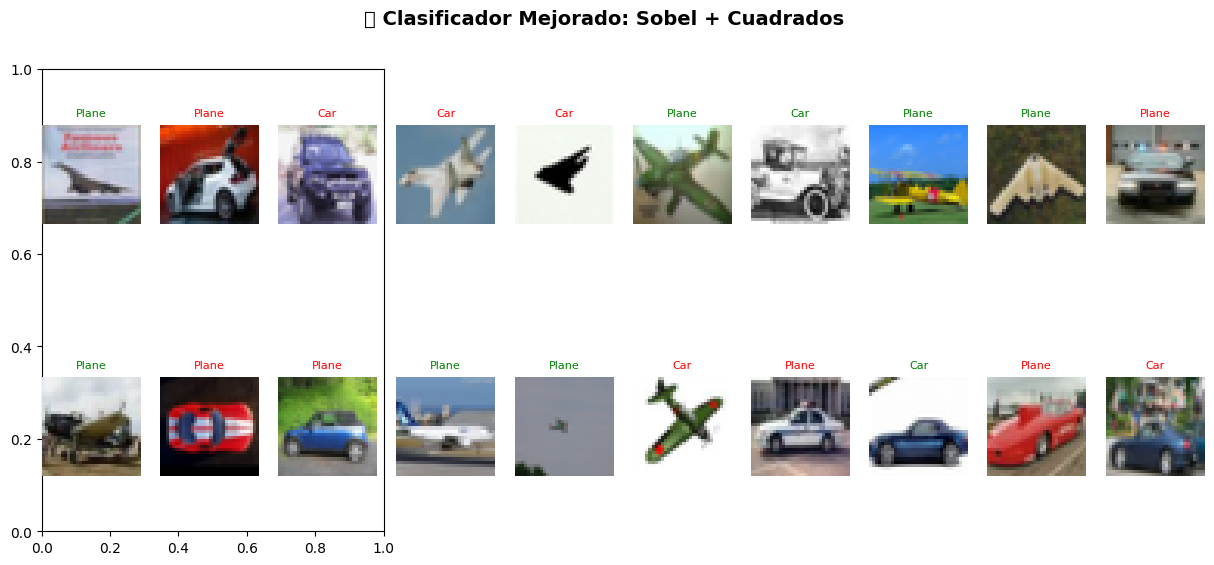


🔍 ANÁLISIS DE MEJORAS:
   Imagen 7: Car → Mejoró con E_Square=2.40
   Imagen 18: Car → Mejoró con E_Square=2.59

💡 El filtro de cuadrados mejoró 2 predicciones
   • Los autos tienen más formas cuadradas (ventanas, carrocería)
   • Los aviones tienen formas más alargadas y aerodinámicas
   • El filtro detecta patrones rectangulares característicos de vehículos


In [ ]:

# Definir el kernel de detección de cuadrados
square_contrast = torch.tensor([
    [-1, -1, -1, -1, -1],
    [-1,  2,  2,  2, -1],
    [-1,  2,  2,  2, -1],
    [-1,  2,  2,  2, -1],
    [-1, -1, -1, -1, -1],
], dtype=torch.float32).view(1, 1, 5, 5)

def square_features(img):
    """Extrae características usando el filtro de cuadrados"""
    gray = to_gray(img)
    square_response = F.conv2d(gray, square_contrast, padding=2)
    energy_square = square_response.abs().mean().item()
    return energy_square

def classify_with_square_enhanced(ex, ey, es):
    """
    Clasificador mejorado que usa Sobel + filtro de cuadrados
    ex: energía bordes verticales
    ey: energía bordes horizontales  
    es: energía detección cuadrados
    """
    # Los autos tienen más formas cuadradas/rectangulares (ventanas, carrocería)
    # Los aviones tienen formas más alargadas y menos cuadradas
    
    if es > 2.0 and ey > ex:  # Muchos cuadrados + más bordes horizontales
        return 1  # automobile
    elif ey > ex:  # Más bordes horizontales (alas de avión)
        return 0  # airplane
    else:  # Más bordes verticales
        return 1  # automobile

# Aplicar el clasificador mejorado
predictions_enhanced = []

print("🔲 CLASIFICADOR MEJORADO: Sobel + Detección de Cuadrados")
print("="*70)
print(f"{'Imagen':<8} {'Real':<8} {'Pred':<8} {'E_X':<6} {'E_Y':<6} {'E_Square':<8} {'Correcto':<8}")
print("-"*70)

correct_enhanced = 0

for i, img in enumerate(images):
    ex, ey = sobel_features(img)
    es = square_features(img)
    pred = classify_with_square_enhanced(ex, ey, es)
    predictions_enhanced.append(pred)
    
    real_label = "Plane" if labels[i] == 0 else "Car"
    pred_label = "Plane" if pred == 0 else "Car"
    is_correct = labels[i] == pred
    
    if is_correct:
        correct_enhanced += 1
    
    print(f"{i+1:<8} {real_label:<8} {pred_label:<8} {ex:<6.2f} {ey:<6.2f} {es:<8.2f} {'✓' if is_correct else '✗':<8}")

accuracy_enhanced = correct_enhanced / len(labels)

print(f"\n📊 RESULTADOS COMPARATIVOS:")
print(f"{'Método':<25} {'Accuracy':<10} {'Correctas':<10} {'Total':<8}")
print("-"*50)
print(f"{'Sobel Original':<25} {accuracy*100:<10.2f}% {correct:<10} {len(labels):<8}")
print(f"{'Sobel + Cuadrados':<25} {accuracy_enhanced*100:<10.2f}% {correct_enhanced:<10} {len(labels):<8}")

improvement = accuracy_enhanced - accuracy
print(f"\n{'Mejora:':<25} {improvement*100:+.2f}%")

# Visualizar resultados mejorados
plt.figure(figsize=(15, 6))

# Subplot 1: Comparación de predicciones
plt.subplot(1, 3, 1)
for i, img in enumerate(images):
    plt.subplot(2, 10, i + 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.axis("off")

    true_label = "Plane" if labels[i] == 0 else "Car"
    pred_label = "Plane" if predictions_enhanced[i] == 0 else "Car"
    
    color = "green" if labels[i] == predictions_enhanced[i] else "red"
    plt.title(pred_label, color=color, fontsize=8)

plt.suptitle('🔲 Clasificador Mejorado: Sobel + Cuadrados', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Analizar casos donde el filtro de cuadrados ayudó
print(f"\n🔍 ANÁLISIS DE MEJORAS:")
improvements = 0
for i in range(len(labels)):
    old_correct = labels[i] == predictions[i]
    new_correct = labels[i] == predictions_enhanced[i]
    
    if not old_correct and new_correct:
        improvements += 1
        ex, ey = sobel_features(images[i])
        es = square_features(images[i])
        print(f"   Imagen {i+1}: {['Plane','Car'][labels[i]]} → Mejoró con E_Square={es:.2f}")

print(f"\n💡 El filtro de cuadrados mejoró {improvements} predicciones")
print(f"   • Los autos tienen más formas cuadradas (ventanas, carrocería)")
print(f"   • Los aviones tienen formas más alargadas y aerodinámicas")
print(f"   • El filtro detecta patrones rectangulares característicos de vehículos")

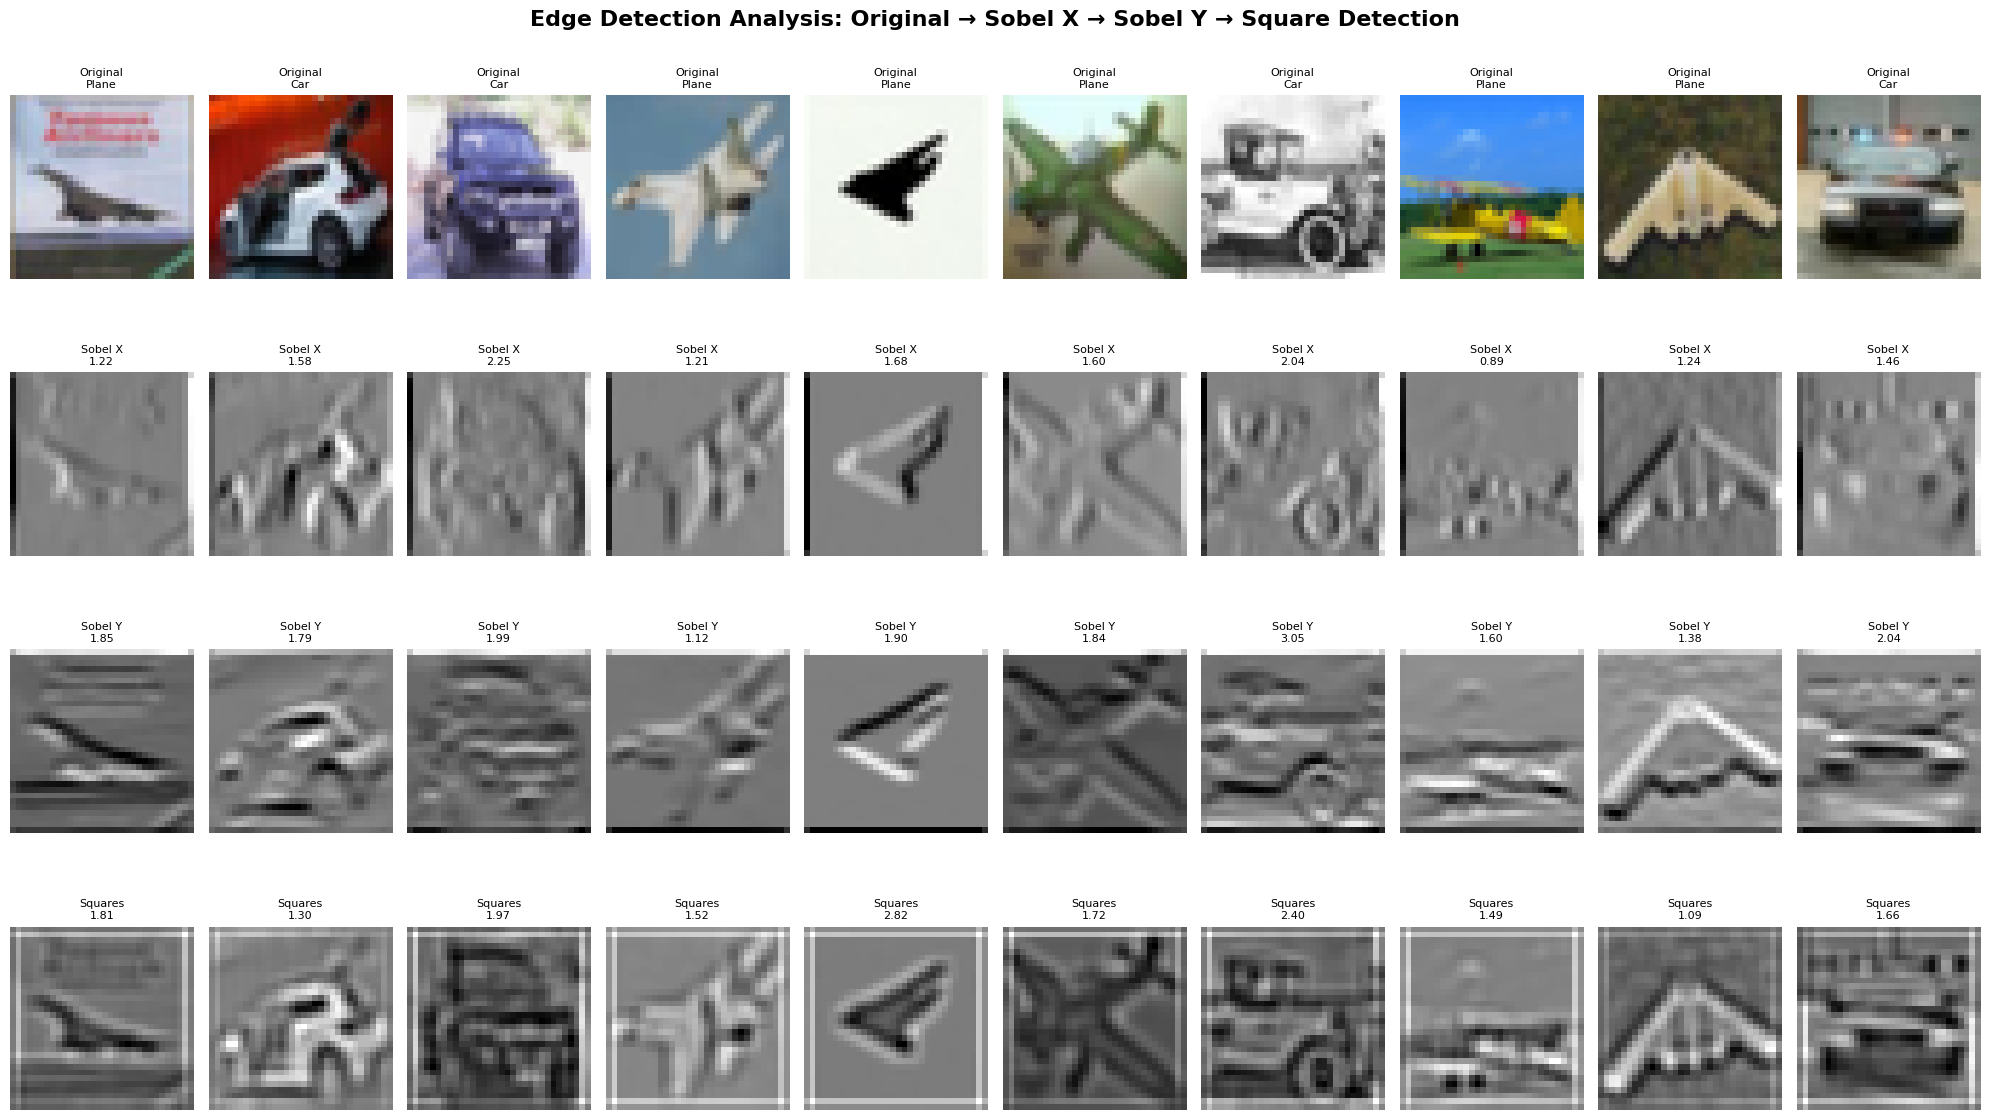

In [78]:
plt.figure(figsize=(20, 12))

for i, img in enumerate(images[:10]):  # Limit to first 10 images to fit in 4x10 grid
    # Convert to grayscale
    gray = to_gray(img)
    
    # Apply Sobel filters
    gx = F.conv2d(gray, sobel_x, padding=1)
    gy = F.conv2d(gray, sobel_y, padding=1)
    
    # Apply square detection filter
    square_response = F.conv2d(gray, square_contrast, padding=2)
    
    # Calculate combined edge magnitude
    edge_magnitude = torch.sqrt(gx**2 + gy**2)
    
    # Original image
    plt.subplot(4, 10, i + 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.axis('off')
    plt.title(f"Original\n{'Plane' if labels[i] == 0 else 'Car'}", fontsize=8)
    
    # Sobel X (vertical edges)
    plt.subplot(4, 10, i + 11)
    plt.imshow(gx.squeeze().detach().numpy(), cmap='gray')
    plt.axis('off')
    plt.title(f"Sobel X\n{sobel_features(img)[0]:.2f}", fontsize=8)
    
    # Sobel Y (horizontal edges)
    plt.subplot(4, 10, i + 21)
    plt.imshow(gy.squeeze().detach().numpy(), cmap='gray')
    plt.axis('off')
    plt.title(f"Sobel Y\n{sobel_features(img)[1]:.2f}", fontsize=8)
    
    # Square detection
    plt.subplot(4, 10, i + 31)
    plt.imshow(square_response.squeeze().detach().numpy(), cmap='gray')
    plt.axis('off')
    plt.title(f"Squares\n{square_features(img):.2f}", fontsize=8)

plt.suptitle('Edge Detection Analysis: Original → Sobel X → Sobel Y → Square Detection', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()